# Семинар: Применение Q-Learning и DQN в Алгоритмической Торговле

В этом семинаре мы создадим торговых агентов, которые будут учиться на исторических данных акций, используя методы обучения с подкреплением (Reinforcement Learning, RL). Мы начнем с базового Q-Learning, а затем перейдем к более продвинутой модели — Deep Q-Network (DQN).

## Постановка задачи

Наш агент управляет портфелем, изначально состоящим из **1000$ наличных**. Он торгует акциями **5** компаний. На каждом шаге (день) агент может выполнить одно из **трех действий**:

1.  **Купить (Buy)**: Потратить все доступные наличные на покупку акций выбранной компании.
2.  **Продать (Sell)**: Продать все акции выбранной компании и получить наличные.
3.  **Удерживать (Hold)**: Ничего не делать.

**Цель агента**: Максимизировать общую прибыль к концу торгового периода. В последний день агент *обязан* продать все акции.

In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Фиксируем сид для воспроизводимости
np.random.seed(42)

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Подготовка и анализ данных

Мы выберем 5 волатильных и интересных компаний: **Tesla (TSLA)**, **Apple (AAPL)**, **Amazon (AMZN)**, **NVIDIA (NVDA)** и **Meta (META)**. Эти акции показывают значительные колебания цен, что делает задачу обучения более интересной.

**Что такое волатильность?**
Волатильность — это мера изменчивости цены актива. Высокая волатильность означает, что цена может сильно колебаться за короткий период. Обычно она измеряется как стандартное отклонение дневных доходностей. Например, если акция имеет среднюю доходность 0.1% в день и стандартное отклонение 2%, то ее цена может легко измениться на ±2% за один день.

In [ ]:
# Определяем тикеры компаний
tickers = ['TSLA', 'AAPL', 'AMZN', 'NVDA', 'META']

# Задаем временной период (например, последние 3 года)
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=3*365)).strftime('%Y-%m-%d')

# Загружаем данные о ценах закрытия
data = yf.download(tickers, start=start_date, end=end_date)['Close']
data = data.dropna()
data.columns = ['Tesla', 'Apple', 'Amazon', 'NVIDIA', 'Meta']

print("Загружено данных:")
print(f"Период: {data.index[0].strftime('%Y-%m-%d')} - {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Количество торговых дней: {len(data)}")
data.head(10)

/tmp/ipython-input-1959812620.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed

Загружено данных:
Период: 2022-09-26 - 2025-09-24
Количество торговых дней: 752


,Tesla,Apple,Amazon,NVIDIA,Meta
Date,,,,,
2022-09-26,148.427017,115.150002,135.534470,12.213326,276.010010
2022-09-27,149.401611,114.410004,133.576538,12.398105,282.940002
2022-09-28,147.511444,118.010002,140.742386,12.720716,287.809998
2022-09-29,140.265839,114.800003,135.574234,12.205339,268.209991
2022-09-30,136.052338,113.000000,134.848679,12.124434,265.250000
2022-10-03,140.236313,115.879997,137.760757,12.496987,242.399994
2022-10-04,143.829590,121.089996,139.420517,13.151199,249.440002
2022-10-05,144.124893,120.949997,138.128479,13.193148,240.809998
2022-10-06,143.169983,120.300003,138.217941,13.114245,238.130005


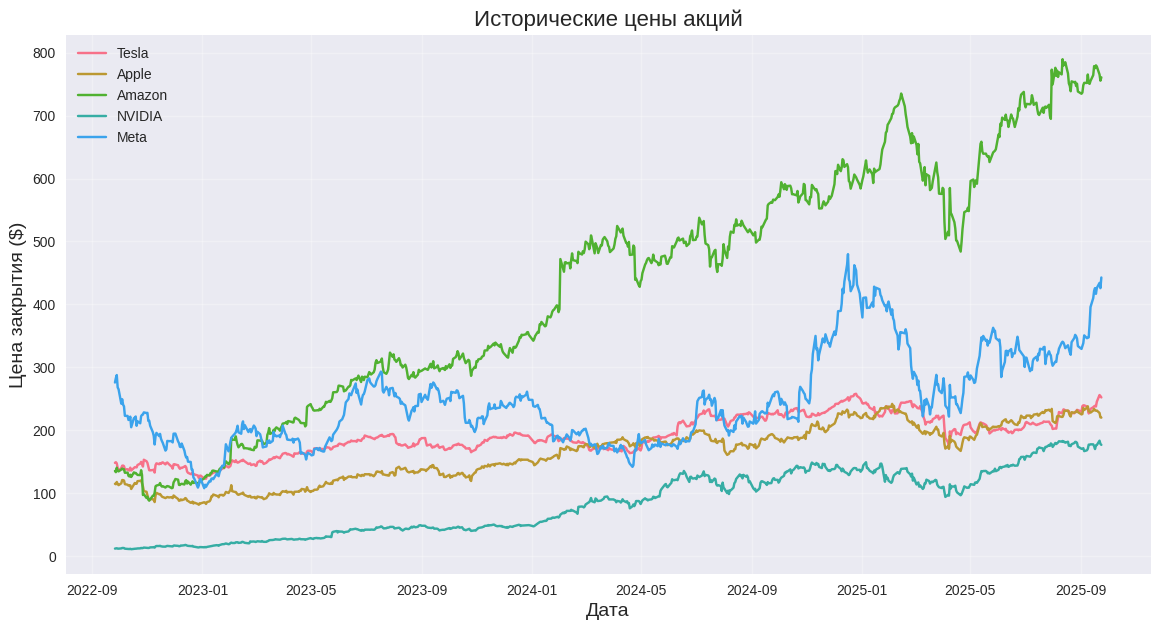

In [ ]:
# Визуализируем исторические цены акций
plt.figure(figsize=(14, 7))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)

plt.title('Исторические цены акций', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена закрытия ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Анализ данных

Давайте посмотрим на волатильность и доходность наших акций. Это поможет понять, какие из них потенциально более прибыльны, но и рискованны.

**Рассчитаем дневные доходности с помощью `data.pct_change()`.**

Метод `pandas.DataFrame.pct_change()` вычисляет процентное изменение между последовательными строками в DataFrame. В контексте цен акций это означает:

$$
\text{Доходность за день } t = \frac{\text{Цена}_t - \text{Цена}_{t-1}}{\text{Цена}_{t-1}} \times 100\%
$$

Где:
*   $\text{Цена}_t$ — цена закрытия в день $t$.
*   $\text{Цена}_{t-1}$ — цена закрытия в предыдущий день $t-1$.

Этот метод создает новый DataFrame, где первая строка будет содержать `NaN` (так как для первого дня нет предыдущей цены для сравнения). Затем мы используем `.dropna()`, чтобы удалить эту строку с `NaN`, получая чистый набор данных с дневными доходностями.

In [ ]:
# Рассчитываем дневные доходности
returns = data.pct_change().dropna()

# Статистика
stats = pd.DataFrame({
    'Средняя дневная доходность (%)': returns.mean() * 100,
    'Стандартное отклонение (%)': returns.std() * 100,
    'Макс. дневной рост (%)': returns.max() * 100,
    'Макс. дневное падение (%)': returns.min() * 100
})

print("Статистика дневных доходностей:")
stats

Статистика дневных доходностей:


,Средняя дневная доходность (%),Стандартное отклонение (%),Макс. дневной рост (%),Макс. дневное падение (%)
Tesla,0.086030,1.761355,15.328847,-9.245607
Apple,0.108968,2.131797,12.177848,-8.979129
Amazon,0.265471,2.675704,23.282407,-24.557077
NVIDIA,0.409920,3.294141,24.369624,-16.968165
Meta,0.139743,3.937536,22.689990,-15.426207


**Что хорошо:**

*   **Высокая средняя доходность (ожидаемая прибыль):** NVIDIA показывает самую высокую среднюю дневную доходность (0.412%), что указывает на то, что в среднем она приносила больше всего прибыли за день за выбранный период. Amazon (0.265%) и Meta (0.135%) также имеют относительно высокую среднюю доходность по сравнению с Tesla и Apple.
*   **Высокий потенциальный рост:** NVIDIA (24.37%) и Amazon (23.28%) показали самые высокие максимальные дневные скачки, что означает, что в отдельные дни они могли принести значительную прибыль. Meta (22.69%) также демонстрирует высокий потенциал роста.

**Что плохо (риск):**

*   **Высокая волатильность (риск):** NVIDIA (3.296%) и Meta (3.938%) имеют самое высокое стандартное отклонение, что означает, что их дневные доходности сильнее всего отклоняются от среднего значения. Это указывает на высокую волатильность и, соответственно, более высокий риск. Meta — самая волатильная. Amazon (2.677%) и Apple (2.133%) также более волатильны, чем Tesla (1.762%).
*   **Значительные дневные падения (риск убытков):** Amazon показал самое сильное дневное падение (-24.56%), что означает, что в худший день инвесторы могли понести значительные убытки. Meta (-15.43%) и NVIDIA (-16.97%) также демонстрируют значительные потенциальные потери в один день. Tesla (-9.25%) и Apple (-8.98%) показали наименьшие максимальные падения в этом наборе.

**Вывод:**

*   **NVIDIA** — потенциально самая прибыльная, но и самая волатильная.
*   **Amazon** — высокая средняя доходность, но сопряжена с высоким риском (как волатильность, так и риск сильного падения).
*   **Meta** — высокая средняя доходность и потенциал роста, но самая волатильная и с высоким риском падения.
*   **Apple** — умеренная средняя доходность и умеренный риск (волатильность), но с хорошим потенциалом роста.
*   **Tesla** — самая стабильная (наименьшая волатильность и наименьшее максимальное падение), но с самой низкой средней доходностью.

Выбор акции зависит от баланса между желанием получить высокую доходность и готовностью принимать на себя риск.

## 2. Разделение данных на тренировочную и тестовую выборки

Для более реалистичной оценки мы разделим данные. Тренировка будет проходить на **каждом третьем дне** из **всех данных, кроме последних 2 месяцев**. Тестирование — на **каждом третьем дне** из **последних 2 месяцев**.

In [ ]:
len(data)

752

Период тренировки (все данные до): 2022-09-26 - 2025-07-25
Период тренировки (каждый 2-й день): 2022-09-26 - 2025-07-24
Количество дней в тренировке: 355
Период тестирования (все данные): 2025-07-28 - 2025-09-24
Период тестирования (каждый 2-й день): 2025-07-28 - 2025-09-23
Количество дней в тесте: 21


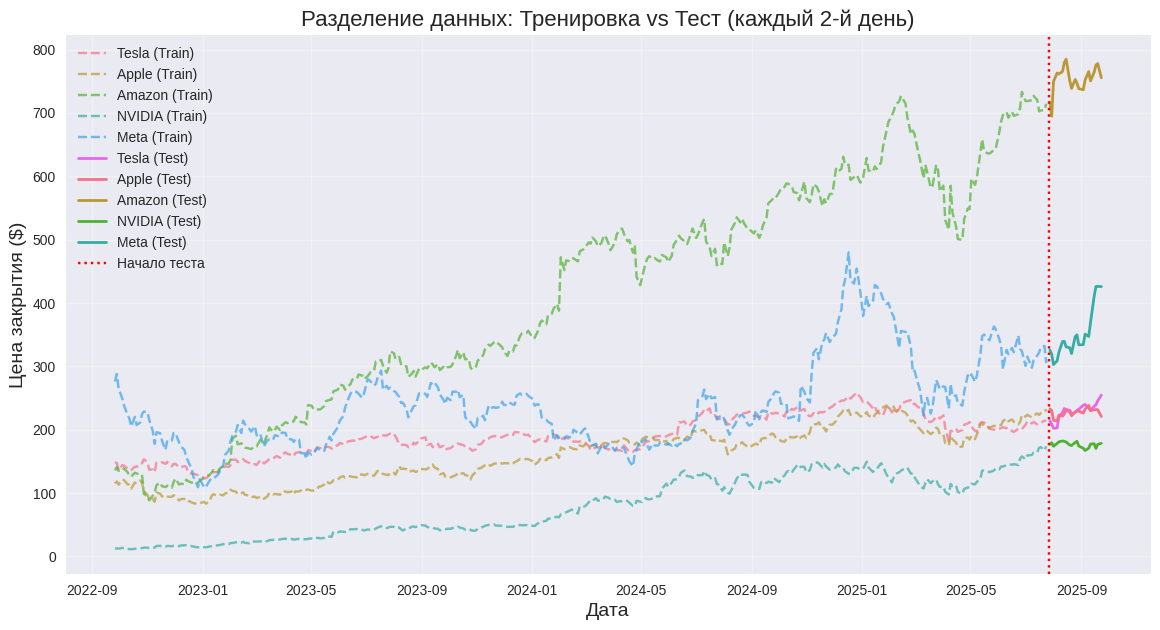

In [ ]:
# Вычисляем дату начала тестового периода (последние 2 месяца)
test_start_date = (datetime.today() - timedelta(days=2*30)).strftime('%Y-%m-%d')

# Разделяем данные
train_data_full = data[data.index < test_start_date]
test_data_full = data[data.index >= test_start_date]

# Берем каждый n-й день для тренировки и теста
n = 2 #если хотим проредить датасет или смотреть на цены не за каждый день
train_data = train_data_full.iloc[::n]
test_data = test_data_full.iloc[::n]

print(f"Период тренировки (все данные до): {train_data_full.index[0].strftime('%Y-%m-%d')} - {train_data_full.index[-1].strftime('%Y-%m-%d')}")
print(f"Период тренировки (каждый {n}-й день): {train_data.index[0].strftime('%Y-%m-%d')} - {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Количество дней в тренировке: {len(train_data)}")
print(f"Период тестирования (все данные): {test_data_full.index[0].strftime('%Y-%m-%d')} - {test_data_full.index[-1].strftime('%Y-%m-%d')}")
print(f"Период тестирования (каждый {n}-й день): {test_data.index[0].strftime('%Y-%m-%d')} - {test_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Количество дней в тесте: {len(test_data)}")

# Визуализация
plt.figure(figsize=(14, 7))
for column in train_data.columns:
    plt.plot(train_data.index, train_data[column], label=f'{column} (Train)', linestyle='--', alpha=0.7)
for column in test_data.columns:
    plt.plot(test_data.index, test_data[column], label=f'{column} (Test)', linewidth=2)

plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle=':', label='Начало теста')
plt.title(f'Разделение данных: Тренировка vs Тест (каждый {n}-й день)', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Цена закрытия ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Создание торговой среды (Environment)

Среда — это симулятор, в котором наш агент будет взаимодействовать с рынком. Она отслеживает состояние портфеля и рассчитывает награду.

**Что такое состояние (state)?**
В нашем случае состояние — это вектор, содержащий:
*   Количество наличных денег.
*   Количество акций каждой компании.
*   Текущие цены акций.

**Что такое награда (reward)?**
Награда — это изменение стоимости портфеля на текущем шаге. Это сигнал для агента: "ты сделал хорошо" или "плохо".

**Сколько всего действий?**
У нас 5 компаний. Для каждой компании есть 2 действия: Buy и Sell. Плюс одно общее действие Hold. Итого: 1 + 2 * 5 = **11 возможных действий**.

In [ ]:
class TradingEnv:
    def __init__(self, data, initial_cash=1000.0):
        """
        Инициализация торговой среды.

        Args:
            data (pd.DataFrame): Данные цен акций с колонками для каждой компании.
            initial_cash (float): Начальное количество наличных денег.
        """
        # Сохраняем переданные данные и начальный капитал
        self.data = data.reset_index(drop=True) # Сбрасываем индекс для простоты индексации
        self.initial_cash = initial_cash
        # Определяем количество и названия компаний
        self.n_companies = len(data.columns)
        self.companies = data.columns.tolist()

        # Сбрасываем состояние среды в начальное
        self.reset()

        # Вычисляем общее количество возможных действий
        # 1 действие 'Hold' + 2 действия ('Buy', 'Sell') для каждой из n_companies
        self.n_actions = 1 + 2 * self.n_companies

        # Вычисляем размер вектора состояния
        # 1 (наличные) + n_companies (акции) + n_companies (цены)
        self.state_size = 1 + self.n_companies + self.n_companies

    def reset(self):
        """Сброс среды в начальное состояние."""
        # Текущий день в симуляции (индекс строки в self.data)
        self.current_step = 0
        # Текущее количество наличных
        self.cash = self.initial_cash
        # Словарь, хранящий количество акций каждой компании
        self.shares = {company: 0 for company in self.companies}
        # История стоимости портфеля на каждом шаге
        self.net_worths = [self.initial_cash]
        # Возвращаем начальное состояние
        return self._get_observation()

    def _get_observation(self):
        """Получить текущее состояние (observation) для агента."""
        # Если мы за пределами данных, цены = 0
        if self.current_step >= len(self.data):
            current_prices = np.zeros(self.n_companies)
        else:
            # Извлекаем цены акций на текущий день
            current_prices = self.data.iloc[self.current_step].values

        # Формируем вектор состояния
        state = np.concatenate([
            [self.cash], # Наличные
            [self.shares[company] for company in self.companies], # Количество акций
            current_prices # Текущие цены
        ])
        return state

    def _take_action(self, action):
        """Выполнить действие агента."""
        # Если это последний шаг, продаем все акции
        if self.current_step == len(self.data) - 1:
            for company in self.companies:
                if self.shares[company] > 0:
                    current_price = self.data.iloc[self.current_step][company]
                    self.cash += self.shares[company] * current_price
                    self.shares[company] = 0
            return

        # Декодируем действие
        if action == 0: # Hold
            pass # Ничего не делаем
        else:
            # Определяем индекс компании и тип действия (Buy/Sell)
            # Формат: [Hold, Buy0, Sell0, Buy1, Sell1, ...]
            company_idx = (action - 1) // 2
            company = self.companies[company_idx]
            action_type = (action - 1) % 2  # 0 = Buy, 1 = Sell

            current_price = self.data.iloc[self.current_step][company]

            if action_type == 0 and self.cash > 0:  # Buy
                # Покупаем максимально возможное количество акций
                shares_to_buy = self.cash // current_price
                if shares_to_buy > 0:
                    self.shares[company] += shares_to_buy
                    self.cash -= shares_to_buy * current_price

            elif action_type == 1 and self.shares[company] > 0:  # Sell
                # Продаем все акции этой компании
                self.cash += self.shares[company] * current_price
                self.shares[company] = 0

    def step(self, action):
        """
        Выполнить шаг в среде.

        Args:
            action (int): Действие, выбранное агентом.

        Returns:
            next_state (np.array): Следующее состояние.
            reward (float): Награда за выполненное действие.
            done (bool): Флаг завершения эпизода.
            info (dict): Дополнительная информация.
        """
        # Сохраняем предыдущую стоимость портфеля
        prev_net_worth = self.cash + sum(self.shares[co] * self.data.iloc[self.current_step][co] for co in self.companies)

        # Выполняем действие
        self._take_action(action)

        # Переходим к следующему шагу
        self.current_step += 1

        # Проверяем, завершен ли эпизод
        done = self.current_step >= len(self.data)

        # Получаем новое состояние
        next_state = self._get_observation() if not done else np.zeros(self.state_size)

        # Рассчитываем награду как изменение стоимости портфеля
        if not done:
            # Обычный шаг: текущая стоимость
            current_net_worth = self.cash + sum(self.shares[co] * self.data.iloc[self.current_step][co] for co in self.companies)
        else:
            # Последний шаг: стоимость после продажи всех акций
            current_net_worth = self.cash

        reward = current_net_worth - prev_net_worth
        # Сохраняем стоимость портфеля для отслеживания
        self.net_worths.append(current_net_worth)

        info = {}

        return next_state, reward, done, info

    def get_results(self):
        """Получить историю стоимости портфеля."""
        return np.array(self.net_worths)

### Тестирование среды

Давайте посмотрим, как работает среда на простом примере. Мы заставим агента просто удерживать портфель (действие 0) и посмотрим на его состояние и награду.

In [ ]:
env = TradingEnv(test_data) # Используем тестовые данные
state = env.reset()

print("Начальное состояние (наличные, акции, цены):")
print(state)

for i in range(5):
    state, reward, done, _ = env.step(0) # Hold
    print(f"Шаг {i+1}: Награда = {reward:.2f}, Состояние = {state}")
    if done:
        break

print(f"\nФинальный капитал после 5 дней удержания: {env.get_results()[-1]:.2f}$")

Начальное состояние (наличные, акции, цены):
[1000.            0.            0.            0.            0.
    0.          213.80735779  232.78999329  717.14599609  176.74003601
  325.58999634]
Шаг 1: Награда = 0.00, Состояние = [1000.            0.            0.            0.            0.
    0.          208.8130188   230.19000244  694.74108887  179.25990295
  319.04000854]
Шаг 2: Награда = 0.00, Состояние = [1000.            0.            0.            0.            0.
    0.          202.15058899  214.75        749.50415039  173.71020508
  302.63000488]
Шаг 3: Награда = 0.00, Состояние = [1000.            0.            0.            0.            0.
    0.          202.68995667  213.75        762.94506836  178.24993896
  308.72000122]
Шаг 4: Награда = 0.00, Состояние = [1000.            0.            0.            0.            0.
    0.          219.78056335  223.13000488  761.31616211  180.7598114
  322.26998901]
Шаг 5: Награда = 0.00, Состояние = [1000.            0.           

Как видите, награда равна нулю, так как мы ничего не делали, а цены акций не влияют на стоимость портфеля, пока мы их не держим.

### Тест: Покупка акции Tesla

In [ ]:
# Создадим новую среду для теста покупки
env_buy_test = TradingEnv(test_data)
initial_state = env_buy_test.reset()

print("=== Тест: Покупка акции Tesla ===")
print(f"Начальное состояние (наличные, акции, цены): {initial_state}")
print(f"Наличные: {initial_state[0]:.2f}$")
print(f"Цены акций: Tesla={initial_state[-3]:.2f}$, Apple={initial_state[-2]:.2f}$, Amazon={initial_state[-1]:.2f}$")

# Предположим, индекс Tesla в списке компаний - 0 (из-за сортировки в TradingEnv)
# Тогда индекс действия "Buy Tesla" = 1 + 0 * 2 = 1
action_buy_tesla = 1

state_after_buy, reward_after_buy, done, _ = env_buy_test.step(action_buy_tesla)

print(f"\nПосле покупки Tesla (действие {action_buy_tesla}):")
print(f"Награда = {reward_after_buy:.2f}$ (ожидаем 0, так как цена не изменилась за день)")
print(f"Состояние: {state_after_buy}")
print(f"Наличные: {state_after_buy[0]:.2f}$")
print(f"Акции Tesla: {state_after_buy[1]} шт.")

# Сделаем еще один шаг Hold
state_hold, reward_hold, done, _ = env_buy_test.step(0)
print(f"\nПосле удержания (Hold):")
print(f"Награда = {reward_hold:.2f}$ (может быть положительной/отрицательной, зависит от изменения цены Tesla)")
print(f"Состояние: {state_hold}")
print(f"Наличные: {state_hold[0]:.2f}$")
print(f"Акции Tesla: {state_hold[1]} шт.")
print(f"Цены акций: Tesla={state_hold[-3]:.2f}$, Apple={state_hold[-2]:.2f}$, Amazon={state_hold[-1]:.2f}$")

print(f"\nФинальный капитал после покупки Tesla и удержания: {env_buy_test.get_results()[-1]:.2f}$")

=== Тест: Покупка акции Tesla ===
Начальное состояние (наличные, акции, цены): [1000.            0.            0.            0.            0.
    0.          213.80735779  232.78999329  717.14599609  176.74003601
  325.58999634]
Наличные: 1000.00$
Цены акций: Tesla=717.15$, Apple=176.74$, Amazon=325.59$

После покупки Tesla (действие 1):
Награда = -19.98$ (ожидаем 0, так как цена не изменилась за день)
Состояние: [144.77056885   4.           0.           0.           0.
   0.         208.8130188  230.19000244 694.74108887 179.25990295
 319.04000854]
Наличные: 144.77$
Акции Tesla: 4.0 шт.

После удержания (Hold):
Награда = -26.65$ (может быть положительной/отрицательной, зависит от изменения цены Tesla)
Состояние: [144.77056885   4.           0.           0.           0.
   0.         202.15058899 214.75       749.50415039 173.71020508
 302.63000488]
Наличные: 144.77$
Акции Tesla: 4.0 шт.
Цены акций: Tesla=749.50$, Apple=173.71$, Amazon=302.63$

Финальный капитал после покупки Tesla и у

## 4. Реализация базовых стратегий

Перед тем как перейти к сложным моделям, сравним их с простыми стратегиями.

**Случайная стратегия** просто выбирает действие наугад. Это наш бейзлайн.

**ε-Жадная стратегия** — это баланс между исследованием (exploration) и использованием (exploitation). С вероятностью `ε` агент исследует (выбирает случайное действие), а с вероятностью `1-ε` он использует свои знания (выбирает лучшее известное действие). В нашем случае "лучшее известное действие" — это покупка акции компании с наивысшей исторической доходностью.

In [ ]:
def run_random_strategy(env, n_episodes=1):
    """Запуск случайной стратегии."""
    all_net_worths = []
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.random.randint(0, env.n_actions)
            state, reward, done, info = env.step(action)
        all_net_worths.append(env.get_results())
    return np.mean(all_net_worths, axis=0)

def run_epsilon_greedy_strategy(env, epsilon=0.1, n_episodes=1):
    """Запуск ε-жадной стратегии."""
    all_net_worths = []
    # Рассчитываем историческую доходность для каждой компании
    returns = {}
    for company in env.companies:
        start_price = env.data[company].iloc[0]
        end_price = env.data[company].iloc[-1]
        returns[company] = (end_price - start_price) / start_price
    # Находим лучшую компанию по доходности
    best_company = max(returns, key=returns.get)
    best_company_idx = env.companies.index(best_company)

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            if np.random.rand() < epsilon:
                # Исследование: случайное действие
                action = np.random.randint(0, env.n_actions)
            else:
                # Использование: покупка/продажа лучшей компании
                if env.cash > 0:
                    # Индекс действия "Buy" для лучшей компании
                    action = 1 + best_company_idx * 2
                else:
                    # Если денег нет, продаем акции лучшей компании, если они есть, или удерживаем
                    if env.shares[best_company] > 0:
                        # Индекс действия "Sell" для лучшей компании
                        action = 1 + best_company_idx * 2 + 1
                    else:
                        action = 0 # Hold
            state, reward, done, info = env.step(action)
        all_net_worths.append(env.get_results())
    return np.mean(all_net_worths, axis=0)

In [ ]:
# Словари для хранения результатов всех стратегий
df_dict_train = {}
df_dict_test = {}

Тестируем случайную стратегию (тест на тренировке)...
Тестируем случайную стратегию (тест на тесте)...

Тестируем ε-жадную стратегию (тест на тренировке)...
Тестируем ε-жадную стратегию (тест на тесте)...


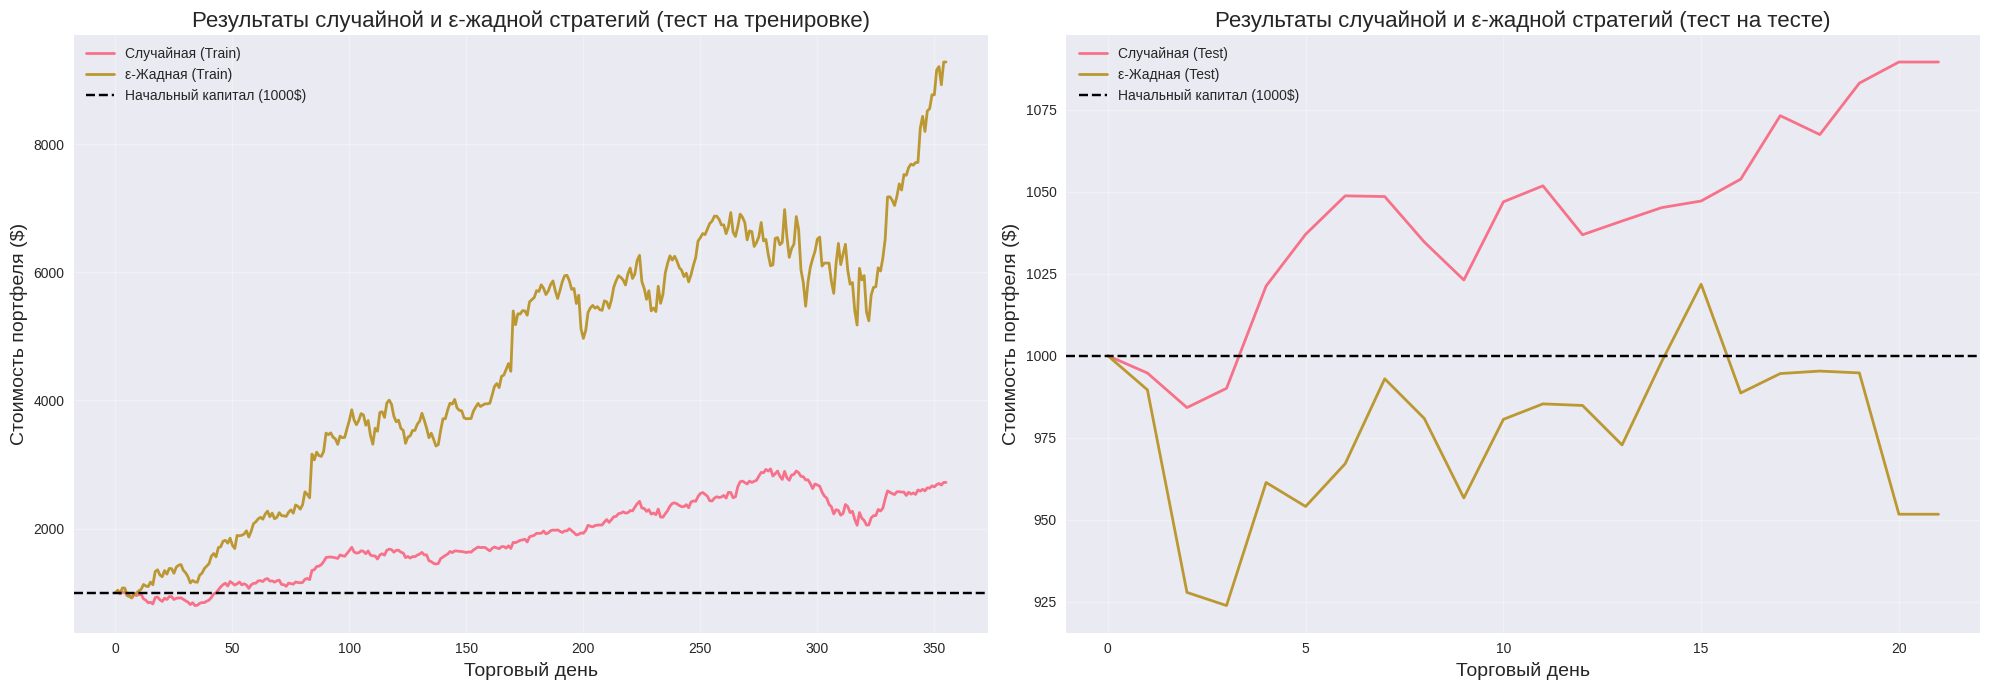

In [ ]:
# Тестируем случайную стратегию на ТРЕНИРОВОЧНЫХ данных
print("Тестируем случайную стратегию (тест на тренировке)...")
env_eval = TradingEnv(train_data)
df_dict_train['Случайная'] = run_random_strategy(env_eval, n_episodes=10)

# Тестируем случайную стратегию на ТЕСТОВЫХ данных
print("Тестируем случайную стратегию (тест на тесте)...")
env_eval = TradingEnv(test_data)
df_dict_test['Случайная'] = run_random_strategy(env_eval, n_episodes=10)

# Тестируем ε-жадную стратегию на ТРЕНИРОВОЧНЫХ данных
print("\nТестируем ε-жадную стратегию (тест на тренировке)...")
env_eval = TradingEnv(train_data)
df_dict_train['ε-Жадная'] = run_epsilon_greedy_strategy(env_eval, epsilon=0.1, n_episodes=1)

# Тестируем ε-жадную стратегию на ТЕСТОВЫХ данных
print("Тестируем ε-жадную стратегию (тест на тесте)...")
env_eval = TradingEnv(test_data)
df_dict_test['ε-Жадная'] = run_epsilon_greedy_strategy(env_eval, epsilon=0.1, n_episodes=1)

# Визуализация результатов случайной и ε-жадной стратегий
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for strategy in ['Случайная', 'ε-Жадная']:
    axes[0].plot(df_dict_train[strategy], label=f'{strategy} (Train)', linewidth=2)
    axes[1].plot(df_dict_test[strategy], label=f'{strategy} (Test)', linewidth=2)

axes[0].axhline(y=1000, color='black', linestyle='--', label='Начальный капитал (1000$)')
axes[0].set_title('Результаты случайной и ε-жадной стратегий (тест на тренировке)', fontsize=16)
axes[0].set_xlabel('Торговый день', fontsize=14)
axes[0].set_ylabel('Стоимость портфеля ($)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].axhline(y=1000, color='black', linestyle='--', label='Начальный капитал (1000$)')
axes[1].set_title('Результаты случайной и ε-жадной стратегий (тест на тесте)', fontsize=16)
axes[1].set_xlabel('Торговый день', fontsize=14)
axes[1].set_ylabel('Стоимость портфеля ($)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Простой Q-Learning агент

**Q-обучение** — это off-policy алгоритм на основе TD (Temporal Difference).
Он обучается функции ценности действий Q(s, a), которая оценивает ожидаемую дисконтированную награду при выполнении действия $a$ в состоянии $s$, и далее следовании жадной политике (всегда выбирая наилучшее действие).

### Правило обновления

Шаг обновления для Q-обучения:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \Big[ r + \gamma \max_{a’} Q(s’,a’) - Q(s,a) \Big]
$$

где:
- $\alpha$ — скорость обучения
- $\gamma$ — коэффициент дисконтирования
- $r$ — награда, полученная после выполнения действия a в состоянии s
- $s’$ — следующее состояние
- $\max_{a’} Q(s’,a’)$ — оценка оптимальной будущей ценности

### Основные свойства

- off-policy: агент обучается относительно жадной (оптимальной) политики, даже если во время тренировки он следует ε-жадной стратегии исследования.
- Оптимистичное обучение: Q-обучение предполагает, что в будущем всегда будет выбрано наилучшее действие.
- Исследование (exploration): на практике используется $\epsilon$-жадная стратегия, чтобы балансировать исследование и использование уже известных действий.

### Интуиция

Q-обучение стремится сходиться к оптимальной политике независимо от того, как агент действует во время тренировки (при условии, что все действия пробуются бесконечно часто).
Это делает алгоритм мощным, но в рискованных средах (например, CliffWalking) он может выбирать опасные кратчайшие пути, потому что планирует так, как будто в будущем всегда будет действовать жадно, несмотря на то что исследовательские шаги могут приводить к ошибкам.

В нашем случае пространство состояний непрерывно, поэтому мы используем грубую дискретизацию (по шагу и наличию денег) для создания табличного агента.

In [ ]:
class QLearningAgent:
    def __init__(self, state_size, n_actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Инициализация Q-Learning агента.

        Args:
            state_size (int): Размер вектора состояния (не используется напрямую в табличной версии).
            n_actions (int): Количество возможных действий.
            learning_rate (float): Скорость обучения (α).
            discount_factor (float): Коэффициент дисконтирования (γ).
            epsilon (float): Начальное значение ε для ε-жадной стратегии.
            epsilon_decay (float): Коэффициент затухания ε.
            epsilon_min (float): Минимальное значение ε.
        """
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Для простоты, создадим очень грубую дискретизацию состояния.
        # Мы будем использовать только индекс текущего шага и бинарный флаг "есть ли наличные".
        # Это сильное упрощение, но позволяет создать табличного агента.
        self.n_steps = 100  # Мы сгруппируем все шаги в 100 "бакетов"
        self.n_cash_states = 2  # 0: нет денег, 1: есть деньги

        # Инициализация Q-таблицы: Q[step_bucket][cash_state][action]
        self.q_table = np.zeros((self.n_steps, self.n_cash_states, self.n_actions))

    def _discretize_state(self, state, current_step, max_steps):
        """Дискретизация состояния для использования в Q-таблице."""
        # Берем только шаг и наличие наличных
        step_bucket = min(int((current_step / max_steps) * self.n_steps), self.n_steps - 1)
        cash_state = 1 if state[0] > 0 else 0  # state[0] - это количество наличных

        return step_bucket, cash_state

    def choose_action(self, state, current_step, max_steps, is_training=True):
        """Выбрать действие на основе ε-жадной стратегии."""
        if is_training and np.random.rand() < self.epsilon:
            # Исследование
            return np.random.randint(0, self.n_actions)
        else:
            # Использование: выбираем действие с максимальным Q-значением
            step_bucket, cash_state = self._discretize_state(state, current_step, max_steps)
            ### ВАШ КОД
            return np.argmax(self.q_table[step_bucket, cash_state])
            ### ВАШ КОД ЗАКОНЧИЛСЯ

    def learn(self, state, action, reward, next_state, done, current_step, max_steps):
        """Обновить Q-таблицу на основе полученного опыта."""
        # Дискретизируем текущее состояние
        step_bucket, cash_state = self._discretize_state(state, current_step, max_steps)

        if not done:
            # Дискретизируем следующее состояние
            next_step_bucket, next_cash_state = self._discretize_state(next_state, current_step + 1, max_steps)
            # Q-Learning update rule: Q(s,a) = Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
            ### ВАШ КОД
            target = reward + self.discount_factor*(self.q_table[next_step_bucket, next_cash_state, action])
            ### ВАШ КОД ЗАКОНЧИЛСЯ
        else:
            # Если эпизод завершен, будущая ценность = 0
            target = reward

        # Обновляем Q-значение для текущей пары (состояние, действие)
        ### ВАШ КОД
        self.q_table[step_bucket, cash_state, action]+= self.learning_rate*(target-self.q_table[step_bucket, cash_state, action])
        ### ВАШ КОД ЗАКОНЧИЛСЯ

    def decay_epsilon(self):
        """Уменьшить значение ε."""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Обучение Q-Learning агента (на тренировке)...
Эпизод 50/200, Средняя награда (посл. 50): 2525.14
Эпизод 100/200, Средняя награда (посл. 50): 3046.97
Эпизод 150/200, Средняя награда (посл. 50): 4319.37
Эпизод 200/200, Средняя награда (посл. 50): 6120.07


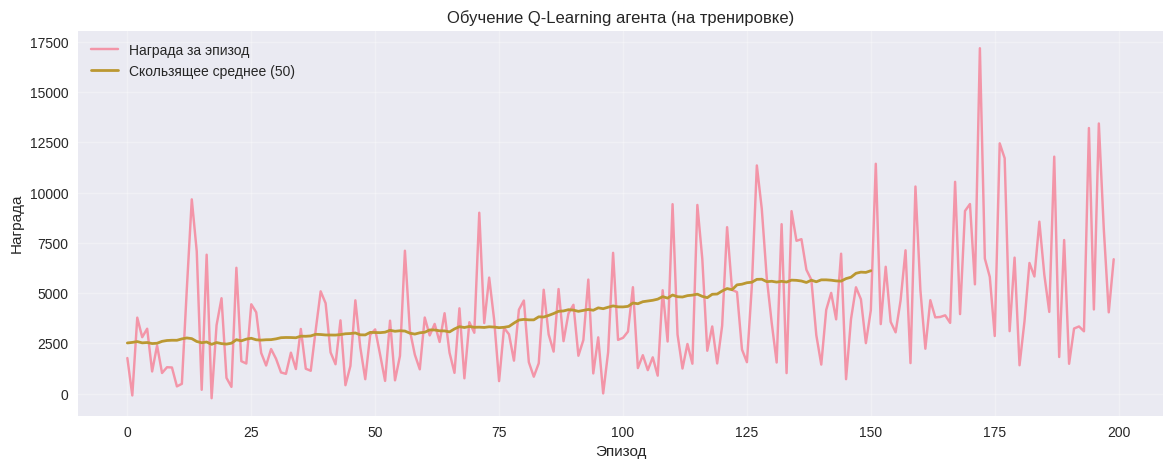

In [ ]:

# Обучаем Q-Learning агента на ТРЕНИРОВОЧНЫХ данных
print("\nОбучение Q-Learning агента (на тренировке)...")
env_train = TradingEnv(train_data)
ql_agent = QLearningAgent(state_size=env_train.state_size, n_actions=env_train.n_actions)
ql_episode_rewards = []
for episode in range(200): # Уменьшено количество эпизодов
    state = env_train.reset()
    total_reward = 0
    done = False
    while not done:
        action = ql_agent.choose_action(state, env_train.current_step, len(env_train.data), is_training=True)
        next_state, reward, done, _ = env_train.step(action)
        ql_agent.learn(state, action, reward, next_state, done, env_train.current_step-1, len(env_train.data))
        state = next_state
        total_reward += reward
    ql_agent.decay_epsilon()
    ql_episode_rewards.append(total_reward)

    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(ql_episode_rewards[-50:])
        print(f"Эпизод {episode + 1}/200, Средняя награда (посл. 50): {avg_reward:.2f}")

# Тестируем Q-Learning агента на ТРЕНИРОВОЧНЫХ данных
env_eval = TradingEnv(train_data)
state = env_eval.reset()
done = False
while not done:
    action = ql_agent.choose_action(state, env_eval.current_step, len(env_eval.data), is_training=False)
    state, _, done, _ = env_eval.step(action)
df_dict_train['Q-Learning'] = env_eval.get_results()

# Тестируем Q-Learning агента на ТЕСТОВЫХ данных
env_eval = TradingEnv(test_data)
state = env_eval.reset()
done = False
while not done:
    action = ql_agent.choose_action(state, env_eval.current_step, len(env_eval.data), is_training=False)
    state, _, done, _ = env_eval.step(action)
df_dict_test['Q-Learning'] = env_eval.get_results()

# Визуализация наград Q-Learning агента
plt.figure(figsize=(14, 5))
plt.plot(ql_episode_rewards, label='Награда за эпизод', alpha=0.7)
plt.plot([np.mean(ql_episode_rewards[i-49:i+1]) for i in range(49, len(ql_episode_rewards))], label='Скользящее среднее (50)', linewidth=2)
plt.title('Обучение Q-Learning агента (на тренировке)')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Deep Q-Network (DQN)

Табличный Q-Learning не масштабируется на задачи с большим пространством состояний. **DQN** решает эту проблему, используя нейронную сеть для аппроксимации Q-функции.

**Ключевые идеи DQN:**
1.  **Experience Replay**: Агент сохраняет свой опыт (s, a, r, s') в буфер и обучается на случайных мини-батчах из этого буфера. Это разбивает корреляции в данных и стабилизирует обучение.
2.  **Target Network**: Используется отдельная целевая сеть для расчета целевых Q-значений. Эта сеть обновляется редко (например, каждые N шагов), что делает обучение более стабильным.

**Ограничения DQN:**
*   Может **переоценивать** Q-значения, так как использует ту же сеть для выбора и оценки действия.
*   Обучение может быть медленным и требует много памяти для буфера воспроизведения.

Мы реализуем две версии DQN:
1.  **DQN без Experience Replay**: Агент обновляется сразу после каждого шага. Это нестабильно и неэффективно.
2.  **Полноценный DQN**: С Experience Replay и Target Network.

**Интуиция DQN:**
Вместо хранения Q-значений в таблице, DQN использует нейронную сеть `Q(s, a; θ)`, где `θ` — параметры сети. Сеть получает на вход состояние `s` и возвращает Q-значения для всех возможных действий `a`. Это позволяет обрабатывать непрерывные и высокоразмерные пространства состояний.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQNetwork(nn.Module):
    """
    Нейронная сеть для оценки Q-функции.
    Принимает на вход состояние и возвращает Q-значения для всех действий.
    """
    def __init__(self, input_dims, n_actions, fc1_dims=128, fc2_dims=128):
        super(DQNetwork, self).__init__()
        # Полносвязные слои
        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

    def forward(self, state):
        # Прямой проход через сеть
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

### Версия 1: DQN без Experience Replay

In [ ]:
class DQNAgentNoReplay:
    def __init__(self, state_size, n_actions, lr=0.001, gamma=0.99, epsilon=1.0,
                 eps_dec=0.995, eps_min=0.01):
        """
        Инициализация DQN агента без Experience Replay.
        """
        self.state_size = state_size
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min

        # Сеть для оценки Q-значений
        self.q_eval = DQNetwork(state_size, n_actions)
        # Оптимизатор
        self.optimizer = optim.Adam(self.q_eval.parameters(), lr=self.lr)
        # Функция потерь
        self.loss_fn = nn.MSELoss()

    def choose_action(self, observation):
        """Выбор действия на основе ε-жадной стратегии."""
        if np.random.random() > self.epsilon:
            # Использование: выбираем действие с максимальным Q-значением
            state = torch.tensor([observation], dtype=torch.float32)
            ### ВАШ КОД
            q_actions = self.q_eval(state)
            action = torch.argmax(q_actions)
            ### ВАШ КОД ЗАКОНЧИЛСЯ
        else:
            # Исследование: случайное действие
            ### ВАШ КОД
            action = np.random.choice(self.n_actions)
            ### ВАШ КОД ЗАКОНЧИЛСЯ
        return action

    def learn(self, state, action, reward, state_, done):
        """Обучение на одном переходе (s, a, r, s')."""
        # Обнуляем градиенты
        self.optimizer.zero_grad()

        # Конвертируем состояния в тензоры
        state = torch.tensor([state], dtype=torch.float32)
        state_ = torch.tensor([state_], dtype=torch.float32)

        # Получаем предсказанное Q-значение для выбранного действия
        q_pred = self.q_eval.forward(state)[0, action]

        # Рассчитываем целевое Q-значение
        if not done:
            # r + γ * max_a' Q(s', a')
            ### ВАШ КОД
            q_target = reward + self.gamma*torch.max(self.q_eval.forward(state_))
            ### ВАШ КОД ЗАКОНЧИЛСЯ
        else:
            # r, если следующее состояние терминальное
            q_target = reward

        # Вычисляем потери
        loss = self.loss_fn(q_pred, torch.tensor(q_target, dtype=torch.float32))
        # Обратное распространение
        loss.backward()
        # Обновление параметров
        self.optimizer.step()

        # Уменьшаем ε
        self.epsilon = max(self.epsilon * self.eps_dec, self.eps_min)

### Обучение DQN агентов

In [ ]:
def train_dqn_agent_no_replay(env, agent, n_episodes=500): # Уменьшено количество эпизодов
    """Обучение DQN агента без Experience Replay."""
    episode_rewards = []
    episode_net_worths = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            # Обучение сразу после каждого шага
            agent.learn(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        episode_rewards.append(total_reward)
        episode_net_worths.append(env.get_results()[-1])

        if (episode + 1) % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:])
            avg_net_worth = np.mean(episode_net_worths[-50:])
            print(f"Эпизод {episode + 1}/{n_episodes}, Средняя награда: {avg_reward:.2f}, Сред. капитал: {avg_net_worth:.2f}$")

    return episode_rewards, episode_net_worths



## 7. Обучение и тестирование всех агентов

Мы будем накапливать результаты всех стратегий в словарях `df_dict_train` и `df_dict_test` для последующего сравнения. Также будем строить график наград для каждого агента.

**Обучение происходит на тренировочных данных.**
**Тестирование (и сравнение) — на тренировочных и тестовых данных.**


Обучение DQN агента БЕЗ Experience Replay (на тренировке)...


/tmp/ipython-input-1046145219.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float32)


Эпизод 50/500, Средняя награда: 5133.15, Сред. капитал: 6133.15$
Эпизод 100/500, Средняя награда: 8856.08, Сред. капитал: 9856.08$
Эпизод 150/500, Средняя награда: 12214.39, Сред. капитал: 13214.39$
Эпизод 200/500, Средняя награда: 13044.06, Сред. капитал: 14044.06$
Эпизод 250/500, Средняя награда: 12535.44, Сред. капитал: 13535.44$
Эпизод 300/500, Средняя награда: 12967.08, Сред. капитал: 13967.08$
Эпизод 350/500, Средняя награда: 12423.04, Сред. капитал: 13423.04$
Эпизод 400/500, Средняя награда: 13013.24, Сред. капитал: 14013.24$
Эпизод 450/500, Средняя награда: 12741.00, Сред. капитал: 13741.00$
Эпизод 500/500, Средняя награда: 12943.05, Сред. капитал: 13943.05$


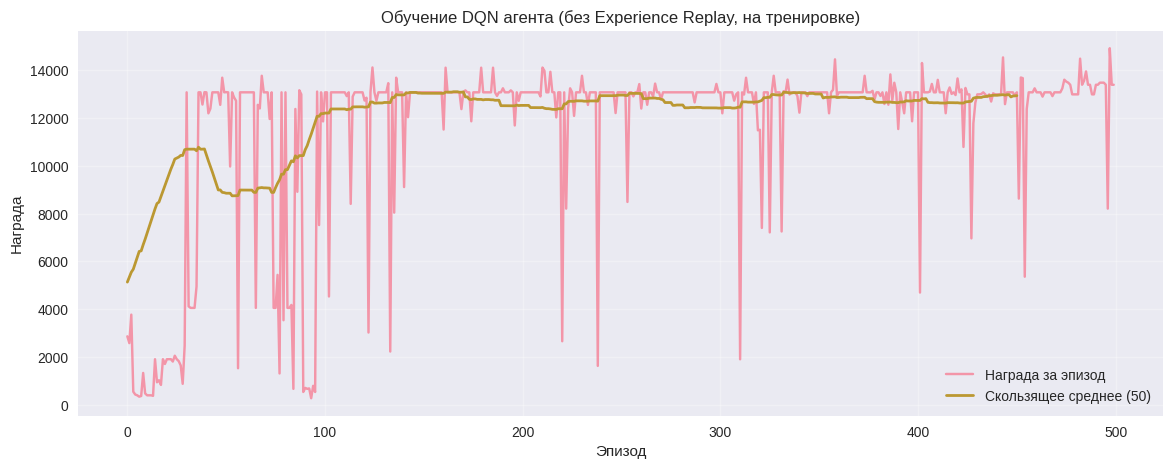

In [ ]:
# Обучаем DQN агента без Experience Replay на ТРЕНИРОВОЧНЫХ данных
print("\nОбучение DQN агента БЕЗ Experience Replay (на тренировке)...")
env_train = TradingEnv(train_data)
dqn_no_replay_agent = DQNAgentNoReplay(state_size=env_train.state_size, n_actions=env_train.n_actions)
dqn_no_replay_rewards, dqn_no_replay_net_worths = train_dqn_agent_no_replay(env_train, dqn_no_replay_agent, n_episodes=500)

# Тестируем DQN агента без Experience Replay на ТРЕНИРОВОЧНЫХ данных
env_eval = TradingEnv(train_data)
state = env_eval.reset()
done = False
while not done:
    action = dqn_no_replay_agent.choose_action(state)
    state, _, done, _ = env_eval.step(action)
df_dict_train['DQN (без Replay)'] = env_eval.get_results()

# Тестируем DQN агента без Experience Replay на ТЕСТОВЫХ данных
env_eval = TradingEnv(test_data)
state = env_eval.reset()
done = False
while not done:
    action = dqn_no_replay_agent.choose_action(state)
    state, _, done, _ = env_eval.step(action)
df_dict_test['DQN (без Replay)'] = env_eval.get_results()

# Визуализация наград DQN агента без Replay
plt.figure(figsize=(14, 5))
plt.plot(dqn_no_replay_rewards, label='Награда за эпизод', alpha=0.7)
plt.plot([np.mean(dqn_no_replay_rewards[i-49:i+1]) for i in range(49, len(dqn_no_replay_rewards))], label='Скользящее среднее (50)', linewidth=2)
plt.title('Обучение DQN агента (без Experience Replay, на тренировке)')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Анализ результатов и визуализация (на тренировочных и тестовых данных)

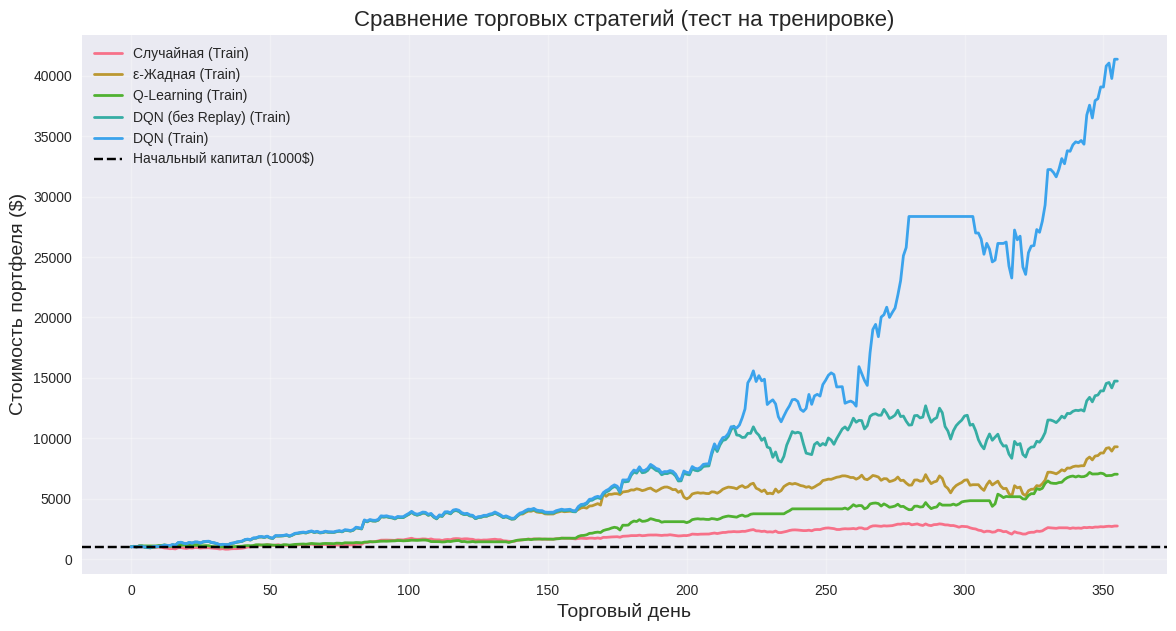

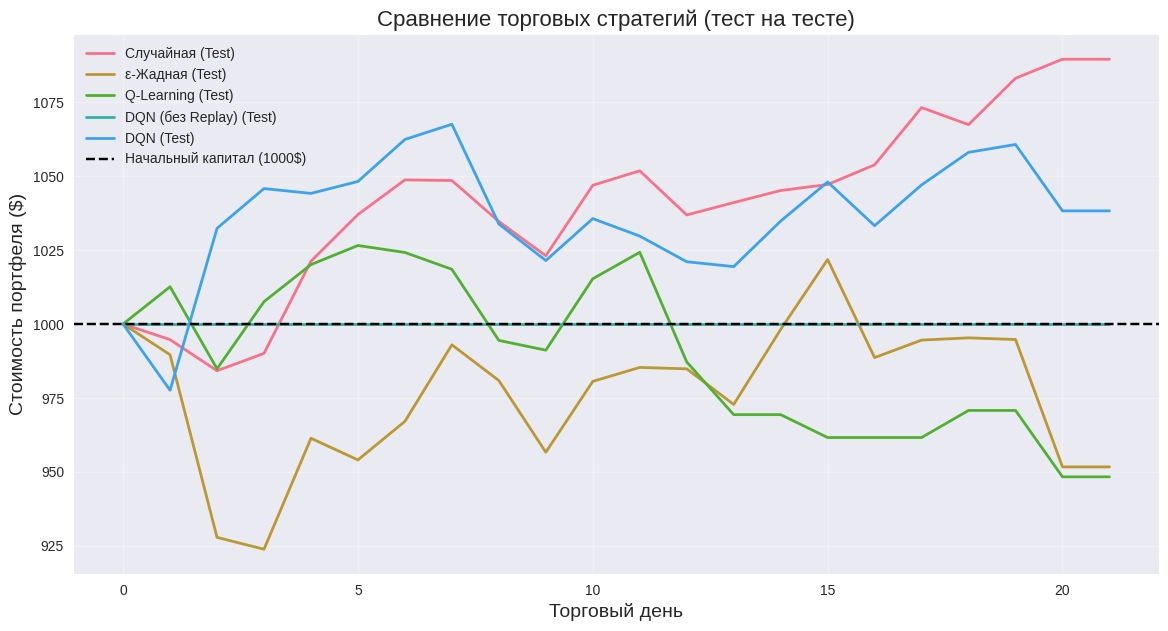

In [ ]:
# Сравнение на тренировке
plt.figure(figsize=(14, 7))
for strategy, results in df_dict_train.items():
    plt.plot(results, label=f'{strategy} (Train)', linewidth=2)

plt.axhline(y=1000, color='black', linestyle='--', label='Начальный капитал (1000$)')
plt.title('Сравнение торговых стратегий (тест на тренировке)', fontsize=16)
plt.xlabel('Торговый день', fontsize=14)
plt.ylabel('Стоимость портфеля ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Сравнение на тесте
plt.figure(figsize=(14, 7))
for strategy, results in df_dict_test.items():
    plt.plot(results, label=f'{strategy} (Test)', linewidth=2)

plt.axhline(y=1000, color='black', linestyle='--', label='Начальный капитал (1000$)')
plt.title('Сравнение торговых стратегий (тест на тесте)', fontsize=16)
plt.xlabel('Торговый день', fontsize=14)
plt.ylabel('Стоимость портфеля ($)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Вывод финальных результатов
print("=== Финальные результаты (тест на тренировке) ===")
for strategy, results in df_dict_train.items():
    final_capital = results[-1]
    profit = final_capital - 1000
    print(f"{strategy}: {final_capital:.2f}$ (Прибыль: {profit:.2f}$)")

print("\n=== Финальные результаты (тест на тесте) ===")
for strategy, results in df_dict_test.items():
    final_capital = results[-1]
    profit = final_capital - 1000
    print(f"{strategy}: {final_capital:.2f}$ (Прибыль: {profit:.2f}$)")

### Анализ переоценки DQN и Q-Learning

Давайте проверим, переоценивает ли наши агенты ценность состояний. Мы сравним их оценку ценности начального состояния с реальным доходом, полученным при следовании их политике.

**Как это работает?**
1.  Мы запускаем агента и записываем последовательность состояний `s[t]` и действий `a[t]`.
2.  Для каждого состояния `s[t]` мы получаем оценку ценности от агента: `V_agent[t] = max_a Q(s[t], a)`.
3.  Параллельно мы вычисляем честный дисконтированный доход `G[t]` из фактически полученных наград.
4.  Если `V_agent[t]` систематически выше `G[t]`, это признак переоценки.

In [ ]:
def get_agent_values_and_returns(env, agent, agent_type='dqn'):
    """Получает оценки ценности и реальные доходы для агента."""
    state = env.reset()
    done = False
    rewards = []
    q_values_max = []

    while not done:
        if agent_type == 'dqn':
            state_tensor = torch.tensor([state], dtype=torch.float32)
            q_vals = agent.q_eval.forward(state_tensor).detach().numpy()[0]
        elif agent_type == 'ql':
            step_bucket, cash_state = agent._discretize_state(state, env.current_step, len(env.data))
            q_vals = agent.q_table[step_bucket, cash_state]
        else:
            q_vals = np.zeros(env.n_actions)

        q_max = np.max(q_vals)
        q_values_max.append(q_max)

        if agent_type == 'dqn':
            action = agent.choose_action(state)
        elif agent_type == 'ql':
            action = agent.choose_action(state, env.current_step, len(env.data), is_training=False)
        else:
            action = 0

        state, reward, done, _ = env.step(action)
        rewards.append(reward)

    gamma = 0.99
    discounted_returns = get_discounted_returns(rewards, gamma)
    return np.array(q_values_max), np.array(discounted_returns)

def get_discounted_returns(rewards: list, gamma: float) -> list:
    """Вычисляет G[t] для каждого t, учитывая награды и гамму."""
    ### ВАШ КОД
    returns_reverse = []
    last_return = 0
    # Итерируемся по наградам в обратном порядке
    for r in reversed(rewards):
        # G[t] = r[t] + gamma * G[t + 1]
        last_return = r + gamma * last_return
        returns_reverse.append(last_return)
    # Разворачиваем список обратно
    returns = list(reversed(returns_reverse))
    return returns
    ###ВАШ КОД ЗАКОНЧИЛСЯ

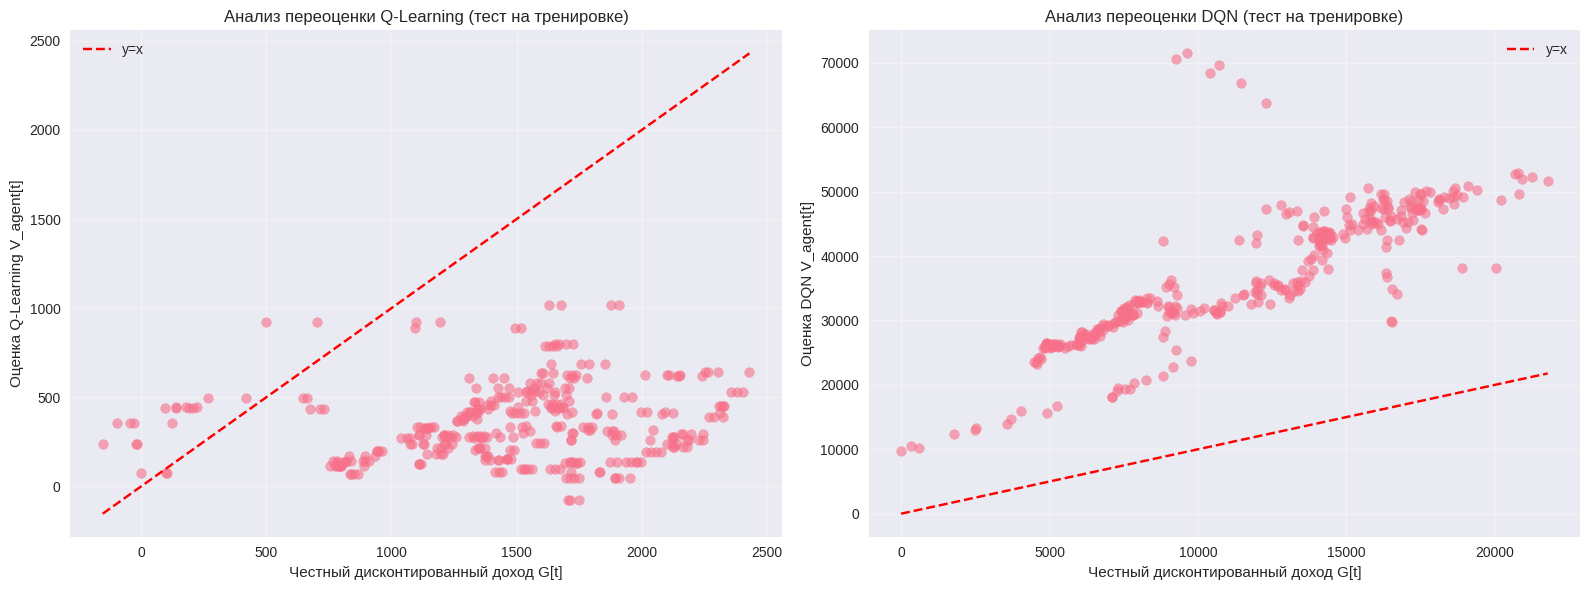

In [ ]:
# Анализ Q-Learning на тренировке
env_eval = TradingEnv(train_data)
v_ql_train, g_ql_train = get_agent_values_and_returns(env_eval, ql_agent, 'ql')

# Анализ DQN на тренировке
env_eval = TradingEnv(train_data)
v_dqn_train, g_dqn_train = get_agent_values_and_returns(env_eval, dqn_agent, 'dqn')

# Визуализация переоценки
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(g_ql_train, v_ql_train, alpha=0.6)
axes[0].plot([g_ql_train.min(), g_ql_train.max()], [g_ql_train.min(), g_ql_train.max()], 'r--', label='y=x')
axes[0].set_xlabel('Честный дисконтированный доход G[t]')
axes[0].set_ylabel('Оценка Q-Learning V_agent[t]')
axes[0].set_title('Анализ переоценки Q-Learning (тест на тренировке)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(g_dqn_train, v_dqn_train, alpha=0.6)
axes[1].plot([g_dqn_train.min(), g_dqn_train.max()], [g_dqn_train.min(), g_dqn_train.max()], 'r--', label='y=x')
axes[1].set_xlabel('Честный дисконтированный доход G[t]')
axes[1].set_ylabel('Оценка DQN V_agent[t]')
axes[1].set_title('Анализ переоценки DQN (тест на тренировке)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Если точки на графике лежат выше красной линии `y=x`, это означает, что агент **переоценивает** ценность состояний. Это известная проблема Q-обучения и DQN.

### Визуализация политики

Политика — это правило, по которому агент выбирает действия. Мы можем визуализировать, какие действия предпочитает агент на разных этапах игры.

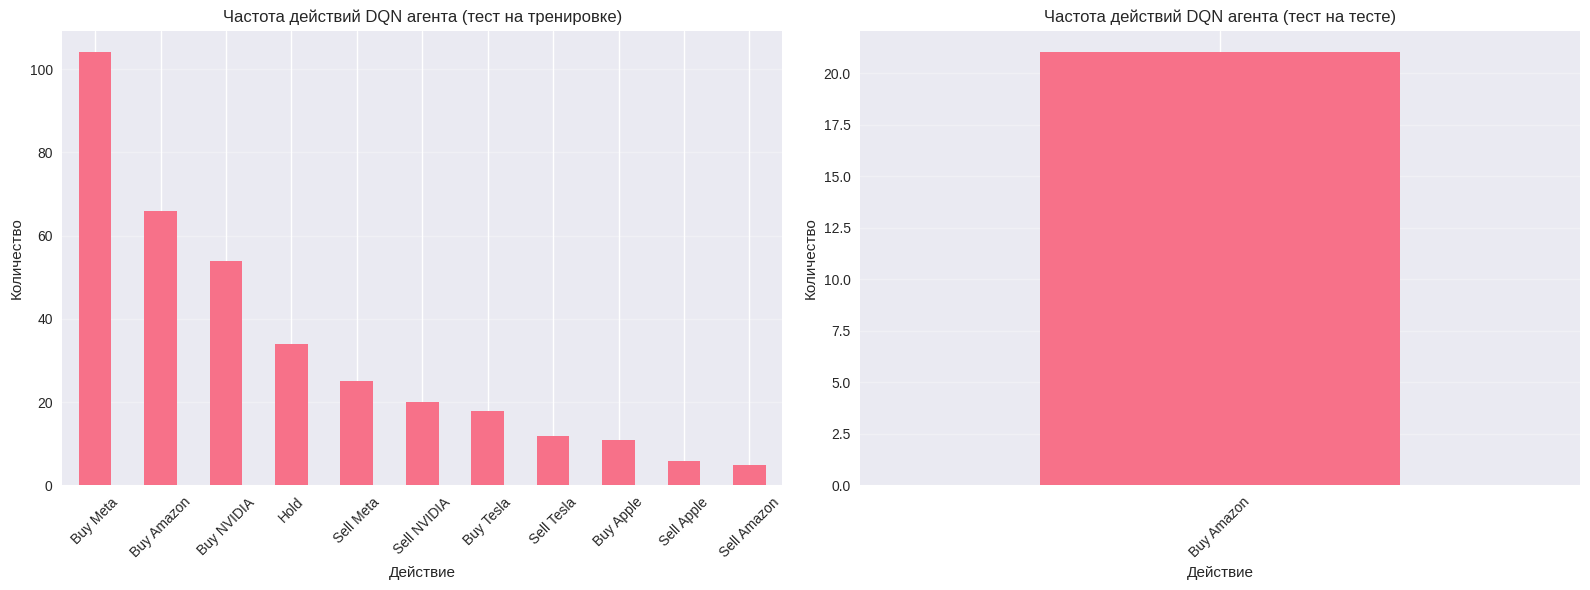

In [ ]:
# Запустите DQN агента и запишите его действия (на тренировке)
env_policy = TradingEnv(train_data)
state = env_policy.reset()
actions_train = []
done = False
while not done:
    action = dqn_agent.choose_action(state)
    actions_train.append(action)
    state, _, done, _ = env_policy.step(action)

# Запустите DQN агента и запишите его действия (на тесте)
env_policy = TradingEnv(test_data)
state = env_policy.reset()
actions_test = []
done = False
while not done:
    action = dqn_agent.choose_action(state)
    actions_test.append(action)
    state, _, done, _ = env_policy.step(action)

# Преобразуем действия в читаемый формат
action_names = ['Hold']
for company in env_policy.companies:
    action_names.append(f'Buy {company}')
    action_names.append(f'Sell {company}')

action_series_train = pd.Series(actions_train).map(lambda x: action_names[x])
action_series_test = pd.Series(actions_test).map(lambda x: action_names[x])

# Построим график частоты действий
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

action_series_train.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Частота действий DQN агента (тест на тренировке)')
axes[0].set_xlabel('Действие')
axes[0].set_ylabel('Количество')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

action_series_test.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Частота действий DQN агента (тест на тесте)')
axes[1].set_xlabel('Действие')
axes[1].set_ylabel('Количество')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Этот график показывает, на каких акциях агент сосредоточил свое внимание. Например, если он часто покупает Tesla, это говорит о том, что модель считает ее наиболее прибыльной в данном историческом периоде.

## 9. Выводы

Мы реализовали и сравнили несколько подходов к алгоритмической торговле:
*   **Случайная стратегия** служит бейзлайном.
*   **ε-Жадная стратегия** использует простую статистику для выбора лучшей акции.
*   **Q-Learning** учится на опыте, но ограничен простым пространством состояний.
*   **DQN без Experience Replay** показывает нестабильное обучение, что подчеркивает важность этой техники.
*   **Полноценный DQN** использует нейронные сети для работы со сложными состояниями и показывает лучшие результаты, но может страдать от переоценки.

Анализ переоценки показал, что оба агента (Q-Learning и DQN) склонны завышать ценность состояний, что является общей проблемой для этих методов. Для решения этой проблемы существуют продвинутые алгоритмы, такие как Double DQN.

Разделение на тренировочную и тестовую выборки позволило оценить, как хорошо агенты обобщают свои знания на *новых* данных. Сравнение результатов на тренировке и тесте помогает понять, не переобучился ли агент.

Этот семинар демонстрирует мощь RL, но также и его сложности. В реальной торговле необходимо учитывать множество дополнительных факторов: комиссии, проскальзывание, рыночный риск и т.д.